交叉熵损失

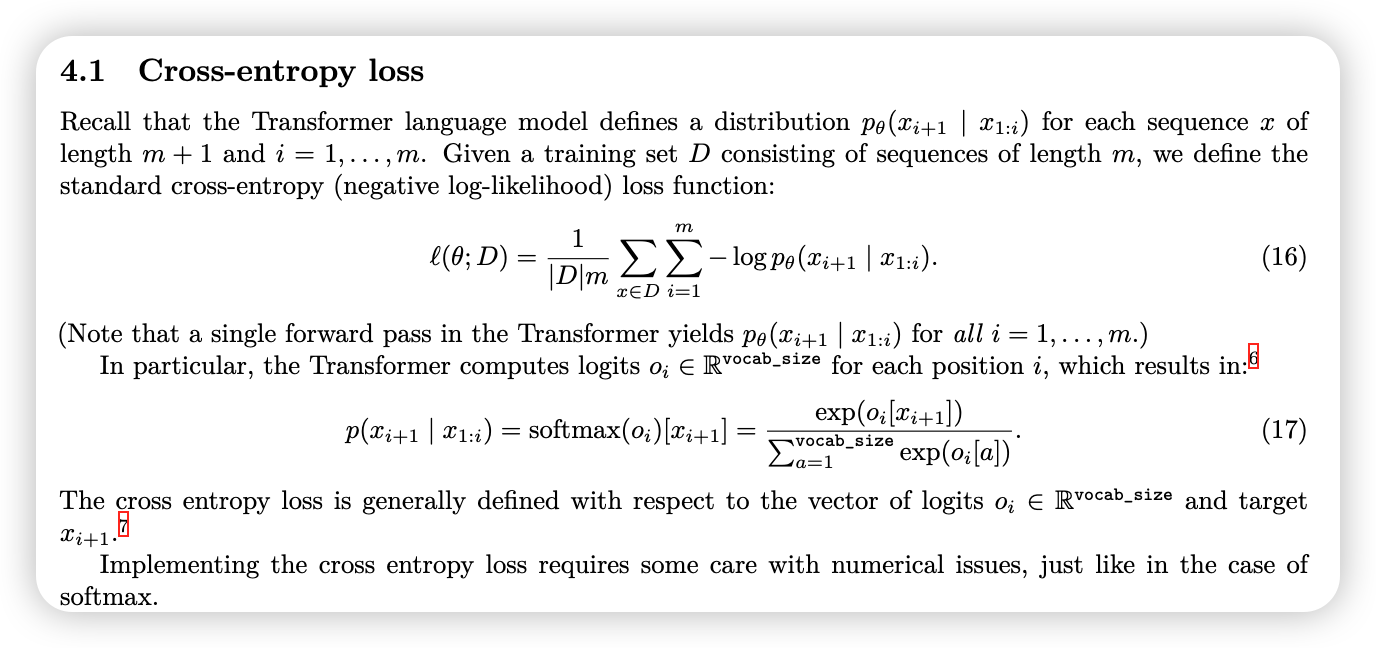

计算这个损失：
最终损失是 所有位置的负 log 概率的平均

就是 对每个序列，每个位置的预测概率求负对数，然后取平均。
等价于最大化真实下一个 token 的对数概率（最小化负对数）

现在还差一个概率 p 在x 前i个位置给定的条件下 ，预测出 x i+1 的概率
这个概率怎么算，直接拿transformer的 这个位置的输出 logits 向量 取softmax当成是概率分布

例如：vocab=3  如果  softmax(o_i) ≈ [0.231, 0.628, 0.141]

第二个是对的token 
那么 p （ x i+1 =“三个词汇里对的那个”｜x 1:i） = 0.628   Loss 位置 i = -log（0.628） =0.464


设：
训练数据集为 D，包含许多序列 X；每个序列x有 m+1 个 token（用于预测 m 次）；模型参数为 θ
我们对每个位置 i=1,…,m，让模型预测下一个 token x i+1，根据之前的 x 1:i
对每个位置i 会得到 一些 logits 向量 oi   ∈R vocab_size



过完 projection layer（就是乘上 W ⊤）后变成：

(2, 128, 50000)
每个位置对应词表中每个词的 logits，接下来就是 softmax ➜ 交叉熵。





logits.shape = (batch_size, seq_len, vocab_size)

变成 logits 向量（维度是 vocab_size，比如 50000）

表示“我猜接下来的词是词表中第 i 个词的概率是多少”

In [ ]:
import torch
from torch import Tensor
from jaxtyping import Float, Int

def run_cross_entropy(
    inputs: Float[Tensor, " batch_size vocab_size"], 
    targets: Int[Tensor, " batch_size"]
) -> Float[Tensor, ""]:
    """
    计算交叉熵损失的数值稳定实现
    
    交叉熵损失是分类任务中最常用的损失函数，特别适用于多分类问题。
    数学公式: CE = -log(P(y_true)) = -log(softmax(x_true))
    
    为了数值稳定性，使用 log-sum-exp 技巧避免指数运算的溢出问题。
    
    参数:
        inputs (Float[Tensor, "batch_size vocab_size"]): 未归一化的 logits
            - inputs[i][j] 表示第 i 个样本属于第 j 个类别的原始得分
            - 通常是神经网络最后一层的输出，未经过 softmax
            - 形状: (batch_size, num_classes)
        targets (Int[Tensor, "batch_size"]): 真实类别标签
            - targets[i] 表示第 i 个样本的真实类别索引
            - 取值范围: [0, num_classes-1]
            - 形状: (batch_size,)

    返回:
        Float[Tensor, ""]: 标量，批次内所有样本的平均交叉熵损失
    """
    
    # 步骤1: 数值稳定性处理 - 减去最大值
    # 目的: 防止 exp(x) 计算时数值溢出
    # 原理: log(softmax(x)) = log(softmax(x - c))，其中 c 是任意常数
    # 选择 c = max(x) 使得所有指数项都 ≤ 1
    dim_max = torch.amax(inputs, dim=-1, keepdim=True)
    #         ↑                    ↑        ↑
    #      取最大值            沿类别维度   保持维度用于广播
    # 形状: (batch_size, 1)
    
    # 步骤2: 将输入平移到数值稳定范围
    # 减去每个样本的最大 logit 值，确保最大值变为0，其他都是负数
    dim_submax = inputs - dim_max
    # 形状: (batch_size, vocab_size) - (batch_size, 1) = (batch_size, vocab_size)
    # 结果: 每行的最大值为0，其他值都是负数，exp 后不会溢出
    
    # 步骤3: 计算 log softmax (数值稳定版本)
    # 标准公式: log_softmax(x_i) = x_i - log(Σ exp(x_j))
    # 这里实现的是: log_softmax(x_i) = (x_i - max) - log(Σ exp(x_j - max))
    
    # 3a. 计算分母: log(Σ exp(x_j - max))
    exp_shifted = torch.exp(dim_submax)  # exp(x - max)，数值稳定
    sum_exp = torch.sum(exp_shifted, dim=-1, keepdim=True)  # Σ exp(x_j - max)
    log_sum_exp = torch.log(sum_exp)  # log(Σ exp(x_j - max))
    
    # 3b. 计算 log softmax
    dim_logsumexp = dim_submax - log_sum_exp
    # 等价于: log_softmax(inputs) = inputs - max - log(sum(exp(inputs - max)))
    # 形状: (batch_size, vocab_size)
    # 物理意义: dim_logsumexp[i][j] = log(P(class=j | sample=i))
    
    # 步骤4: 提取真实类别对应的 log 概率
    # 使用 torch.gather 根据 targets 索引提取对应的 log 概率
    
    # 4a. 准备索引张量
    targets_expanded = targets.unsqueeze(-1)
    # 形状变化: (batch_size,) -> (batch_size, 1)
    # 目的: 匹配 gather 函数的要求
    
    # 4b. 提取对应的负 log 概率
    # 注意: 使用 -dim_logsumexp，因为交叉熵是负对数似然
    neg_log_probs = torch.gather(
        input=-dim_logsumexp,     # 输入张量: 负的 log softmax
        dim=-1,                  # 沿类别维度收集
        index=targets_expanded   # 索引: 真实类别
    )
    # torch.gather 的作用:
    # neg_log_probs[i] = -dim_logsumexp[i][targets[i]]
    # 即提取第 i 个样本在真实类别上的负 log 概率
    # 形状: (batch_size, 1)
    
    # 步骤5: 计算平均损失
    # 去除多余维度并计算批次平均值
    neg_log_probs_squeezed = neg_log_probs.squeeze(-1)  # (batch_size, 1) -> (batch_size,)
    mean_loss = torch.mean(neg_log_probs_squeezed)      # 标量
    
    return mean_loss


通过 反向传播（backpropagation） 来最小化这个 cross-entropy 损失
因为：

cross-entropy loss 是一个可微分的函数
Transformer 中的所有模块（注意力、全连接层、激活函数等）也都是可导的
所以可以使用 链式法则 计算梯度 
 
用梯度下降（如 Adam）来更新模型参数 θ



如果某个 token 被错误预测（比如概率只有 0.01），那么：
损失很大：
−log(0.01)=4.6−log(0.01)=4.6
反向传播时，对应的 logits 会被大力“修正”：
真实 token 的 logit 会被推高
其他 token 的 logit 会被压低